# Finetune Mistral 7b instruct model with Taivob Jokes dataset

Clone the `taivop/joke-dataset` repository first. This repository contains a dataset of English plaintext jokes. There are about 208 000 jokes in this database scraped from three sources.

```
----------------------------------------------
reddit_jokes.json |  195K jokes | 7.40M tokens
stupidstuff.json  | 3.77K jokes |  396K tokens
wocka.json        | 10.0K jokes | 1.11M tokens
----------------------------------------------
TOTAL             |  208K jokes | 8.91M tokens
----------------------------------------------
```

In [1]:
!git clone https://github.com/taivop/joke-dataset.git

Cloning into 'joke-dataset'...
remote: Enumerating objects: 44, done.
remote: Counting objects: 100% (14/14), done.
remote: Compressing objects: 100% (4/4), done.
remote: Total 44 (delta 12), reused 10 (delta 10), pack-reused 30
Receiving objects: 100% (44/44), 32.38 MiB | 13.80 MiB/s, done.
Resolving deltas: 100% (21/21), done.
Updating files: 100% (9/9), done.


Install all the required packages

In [2]:
!pip install -q transformers>=4.32.0 optimum>=1.12.0
!pip install -q auto-gptq --extra-index-url https://huggingface.github.io/autogptq-index/whl/cu118/
!pip install -q accelerate
!pip install -q peft
!pip install -q datasets
!pip install -q huggingface_hub

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.0/5.0 MB 21.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 261.4/261.4 kB 3.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.2/12.2 MB 17.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 174.7/174.7 kB 9.4 MB/s eta 0:00:00


### Load the Data

In [3]:
import pandas as pd
import string

stupidstaff jokes contains 3.77k jokes, with additional information like category and ratings. Additionally, `n_words` columns has been created to keep track of number of words in a joke.

In [4]:
stupid_jokes = pd.read_json('/content/joke-dataset/stupidstuff.json')
stupid_jokes['n_words'] = stupid_jokes['body'].str.split().apply(len)
stupid_jokes.loc[ stupid_jokes["n_words"] > 180, "rating"] = 2.0
stupid_jokes.head()

,body,category,id,rating,n_words
0,A blackjack dealer and a player with a thirtee...,Children,1,2.63,102
1,"At a dinner party, several of the guests were ...",Blonde Jokes,2,2.57,80
2,One day this cop pulls over a blonde for speed...,Blonde Jokes,3,3.09,46
3,Three women are about to be executed for crime...,Blonde Jokes,4,4.10,156
4,A girl came skipping home FROM school one day....,Blonde Jokes,5,2.00,185


In [13]:
stupid_jokes['category'].value_counts()

Miscellaneous      831
Insults            196
Men                190
Religious          152
Computers          150
Women              144
Yo Mama            141
Political          141
Animals            131
Light Bulbs        120
Blonde Jokes       111
Business           104
Medical            101
Family, Parents     96
Heaven and Hell     91
Bar Jokes           87
Children            82
Money               82
Holidays            69
Police Jokes        67
School              62
Sports              61
Military            58
Sex                 54
Lawyers             50
Love & Romance      48
Crazy Jokes         43
Marriage            37
Aviation            35
Idiots              31
Farmers             29
One Liners          28
Redneck             27
Old Age             22
Science             18
Office Jokes        18
Deep Thoughts       14
Food Jokes          13
Blind Jokes         11
State Jokes         10
Music                9
Ethnic Jokes         8
English              1
Name: categ

<Axes: ylabel='Frequency'>

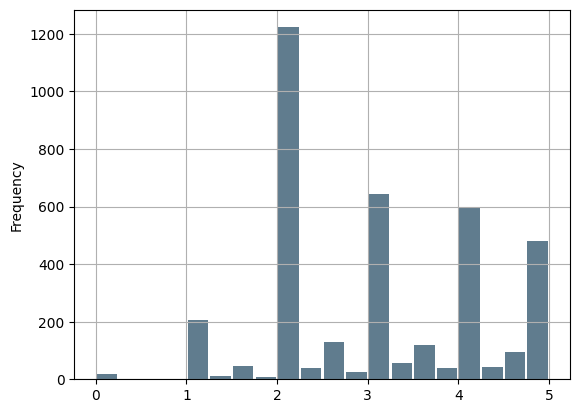

In [6]:
stupid_jokes['rating'].plot.hist(grid=True, bins=20, rwidth=0.9, color='#607c8e')

wocka jokes contains 10.0k jokes, with additional information like category and joke title. Additionally, `n_words` columns has been created to keep track of number of words in a joke.

In [7]:
wocka_jokes = pd.read_json('/content/joke-dataset/wocka.json')
wocka_jokes['n_words'] = wocka_jokes['body'].str.split().apply(len)
wocka_jokes.head()

,body,category,id,title,n_words
0,What do you call a cow with no legs?\r\n\r\nGr...,Animal,1,Cow With No Legs,11
1,What do you call a cow jumping over a barbed w...,Animal,2,Jumping Cow,14
2,What's black and white and red all over?\r\n\r...,Other / Misc,4,"Black, White and Red",10
3,"So, this guy walks into a bar.\r\n\r\nAnd says...",Bar,5,Guy in a Bar,10
4,"If the opposite of pro is con, isn't the oppos...",One Liners,6,Progress,13


In [8]:
wocka_jokes['category'].value_counts()

Other / Misc       2305
Men / Women         925
One Liners          917
Animal              656
Children            605
Yo Momma            600
Blond               598
Puns                457
Religious           402
At Work             288
News / Politics     279
Insults             276
Gross               254
Redneck             241
Medical             208
Knock-Knock         167
Lawyer              157
Bar                 154
Tech                151
Sports              134
College             131
Lightbulb           110
Yo Mama               3
Blonde                1
Name: category, dtype: int64

There are certain jokes which contains length more than 1000 words. These kind of jokes confuses the model while producing jokes. That's why such long jokes are filtered out in later steps with maximum joke length parameter.

In [9]:
wocka_jokes['n_words'].max()

11318

In [10]:
wocka_jokes[wocka_jokes['n_words'] > 120]

,body,category,id,title,n_words
13,Saddam Hussein was sitting in his office wonde...,Other / Misc,15,Hello! Mr Hussein?,373
17,Saddam Hussein and George W. Bush meet up in B...,News / Politics,19,Buttons,273
18,"During the wedding rehearsal, the groom approa...",Men / Women,20,Bride & Groom,212
31,"Economic times were very bad, so the plant own...",At Work,35,Cannibals,142
32,"Jim is in a hot-air balloon, completely lost. ...",At Work,36,Balloon Ride,152
...,...,...,...,...,...
10011,"Employee: *making out a rain check* ""Okay, so ...",At Work,18193,We Need One Of These In Every Store,132
10012,(I'm ringing up a customer and notice her last...,Men / Women,18194,As The Checkout Line Churns,321
10014,(A man comes to my register with a mint chocol...,Men / Women,18196,Hell Hath No Fury Like A Pregnant Woman Scorned,150
10016,"Me: ""That will be 17.50, please.""\r\n\r\nCusto...",Religious,18198,Hell In A Handbag,171


### Create Joke telling dataset

In [11]:
max_joke_len = 100

There are 43 different category jokes are available in this stupidstaff jokes dataset. A category keyword map has been used to create more dynamic prompt from the jokes.

In [14]:
category_keyword_map = {
    'Children': 'child, little boy, mom and dad, etc',
    'Blonde Jokes': 'women, girl, blonde, etc',
    'Military': 'captain, world war, enemy, soldier, etc',
    'Office Jokes': 'office, boss, factory, accountant, etc',
    'Aviation': 'airplane, fly, plane, boarding, etc',
    'Political': 'Bill and Hillary Clinton, George Bush, president, etc',
    'Deep Thoughts': 'laughs, good friend, cry, love, etc',
    'Men': 'man, bar, husband, sports, guys, etc',
    'Crazy Jokes': 'psychiatrist, ambulance, city, etc',
    'Medical': 'hospital, operation, eldarly, doctor, etc',
    'Food Jokes' : 'breakfast, sandwich, order, coffee, etc',
    'Bar Jokes' : 'pub, drunk, beer, wine, etc',
    'Science' : 'scientist, medical, inventions, physics, etc',
    'Police Jokes' : 'policeman, officer, illegal, etc',
    'Miscellaneous' : 'canadians, FBI agent, red light, bottle of whiskey, etc',
    'Sex' : 'virginity, husband and wife, sex, etc',
    'Idiots' : 'friends, tourists, stupid, fool, etc',
    'Business' : 'secretary, office, manager, money, etc',
    'Women' : 'pretty, Romance, money, beautiful, etc',
    'Redneck' : 'dead bodies, bob, billy, redneck, etc',
    'One Liners' : 'dentist, tetanus shot, drivers, etc',
    'Money' : 'dollar, bill, success, Rolex, etc',
    'School' : 'instructor, teacher, student, class, college, etc',
    'Family, Parents' : 'mother, children, jewish, indian, boy, daughter, etc',
    'Sports' : 'athletes, golf, soccer, olympics, football, cricket, etc',
    'Heaven and Hell' : 'preacher, life, death, religion, god, satan, etc',
    'Religious' : 'pope, lord, god, bible, jew, christian, hindu, etc',
    'Farmers' : 'farm, cows, country, etc',
    'Love & Romance' : 'love, couple, boyfriend, girlfriend, etc',
    'Blind Jokes' : 'blind man, vision, etc',
    'Marriage' : 'couple, old man, wife, husband, etc',
    'Old Age' : 'old, elderly, etc',
    'Animals' : 'birds, docs, cats, ducks, chickens, etc',
    'Holidays' : 'jobs, vacation, christmas, thanksgiving, etc',
    'Ethnic Jokes' : 'german, american, indian, polish, muslims, jews, etc',
    'State Jokes' : 'texas, florida, new york, etc',
    'English' : 'language, bristish, words, etc',
    'Computers' : 'engineer, Windows, tech, etc',
    'Lawyers' : 'client, lawyer, money, etc',
    'Yo Mama' : 'fat, stupid, dumb, poor, etc',
    'Insults' : 'pain, dumb, friends, etc',
    'Light Bulbs' : 'bulbs, politics, economists, etc',
}

joke_telling_template = """[INST]Tell a joke about {} using keywords such as {}[/INST]

Here is a joke:
{}"""

def format_categories(category: str):
  keywords = category_keyword_map['Miscellaneous']
  if category in category_keyword_map.keys():
    keywords = category_keyword_map[category]

  category = category.replace('Jokes', '')
  category = category.strip()

  if category == "Miscellaneous":
    category = "Miscellaneous or General topics"

  return category, keywords

# Define a custom function to combine columns
def create_prompt_from_category_n_body(row):
  category, keywords = format_categories(row["category"])
  return joke_telling_template.format(category, keywords, row["body"])

Only short jokes are filtered out which has number of words less than 100.

In [15]:
short_jokes = stupid_jokes[(stupid_jokes['n_words'] > 0) & (stupid_jokes['n_words'] < max_joke_len)]
print(len(stupid_jokes))
print(len(short_jokes))

3773
1566


In [28]:
tell_stupid_jokes_dataset = short_jokes.copy(deep=True)
tell_stupid_jokes_dataset['prompt'] = tell_stupid_jokes_dataset.apply(create_prompt_from_category_n_body, axis=1)

tell_stupid_jokes_dataset.drop(columns=['body', 'category', 'id', 'rating', 'n_words'], inplace=True)
print('number of stupid jokes telling data: ' + str(len(tell_stupid_jokes_dataset)))

number of stupid jokes telling data: 1566


In [17]:
print(tell_stupid_jokes_dataset.iloc[178]['prompt'])

[INST]Tell a joke about Women using keywords such as pretty, Romance, money, beautiful, etc[/INST]

Here is a joke:
Two old ladies were sitting on rocking chairs in their retirement home. One asked, "Do you still ever get horny?"

"Oh, yes!" was the reply.

"What do you do about it?" asked the first.

"I suck on a lifesaver." was the reply.

The first lady sat there for a long while pondering the answer. Finally she couldn't stand it any longer, and asked, 

"Who drives you to the beach?"


### Create Joke rating Dataset

A joke rating dataset has been created using the rating from the stupidstaff jokes dataset. Here all the scores are converted into categories susc as very funny, funny, neutral, not funny and sad. Jokes which has length more than 150 are considered as not funny jokes.

In [19]:
joke_rating_template = """[INST] Classify the humor level of a given joke in 5 classes. Output must be \
a class from one of very funny, funny, neutral, not funny, or sad. [/INST]

Joke: {}
Rating: {}"""

def format_rating_to_class(rating: float):
  if rating > 4.0 and rating <= 5.0:
    return 'very funny'
  elif rating > 3.0 and rating <= 4.0:
    return 'funny'
  elif rating > 2.0 and rating <= 3.0:
    return 'neutral'
  elif rating > 1.0 and rating <= 2.0:
    return 'not funny'
  else:
    return 'sad'

def create_prompt_from_body_and_rating(row):
  rating = format_rating_to_class(row["rating"])
  return joke_rating_template.format(row["body"], rating)

In [27]:
rate_stupid_jokes_dataset = stupid_jokes.copy(deep=True)
rate_stupid_jokes_dataset['prompt'] = rate_stupid_jokes_dataset.apply(create_prompt_from_body_and_rating, axis=1)

rate_stupid_jokes_dataset.drop(columns=['body', 'category', 'id', 'rating', 'n_words'], inplace=True)

print('number of stupid jokes rating data: ' + str(len(rate_stupid_jokes_dataset)))
rate_stupid_jokes_dataset.head()

number of stupid jokes rating data: 3773


,prompt
0,[INST] Classify the humor level of a given jok...
1,[INST] Classify the humor level of a given jok...
2,[INST] Classify the humor level of a given jok...
3,[INST] Classify the humor level of a given jok...
4,[INST] Classify the humor level of a given jok...


In [21]:
print(rate_stupid_jokes_dataset.iloc[70]['prompt'])

[INST] Classify the humor level of a given joke in 5 classes. Output must be a class from one of very funny, funny, neutral, not funny, or sad. [/INST]

Joke: One day, a blonde's neighbor goes over to her house, sees the blonde crying, and asks her what happened. The blonde said that her mother had passed away. The neighbor made her some coffee and calmed her down a little and then left. The next day the neighbor went back over to the house and found the blonde crying again. She asked her why she was crying this time. ''I just got off of the phone with my sister, her mother died too!''
Rating: funny


### Create Wocka Joke telling Dataset

In [22]:
wocka_joke_telling_template = """[INST]Tell me a joke about {}, when the title of the joke is {}.[/INST]

Here is a joke:
{}"""

# Define a custom function to combine columns
def create_prompt_from_category_n_title(row):
  category = row["category"].strip()
  if category == 'Other / Misc':
    category = 'Miscellaneous or General topics'
  title = row['title'].strip()
  return wocka_joke_telling_template.format(category, title, row["body"])

In [23]:
joke_bodies = wocka_jokes[(wocka_jokes['category'] == 'Children') & (wocka_jokes['n_words'] < 50)]['body'].tail()
for b in joke_bodies:
  print(b)
  print('----------------------------')

3 year old kid: "Guess what? Daddy got you a pway-station!"
7 year old kid: "Really??!! Where is it?"
3 year old: "It's in p-one mile!"
----------------------------
Cop to boy: Which of the two fighting in the street is your father?

Boy: I don't know. That's what they're fighting about!
----------------------------
Teacher: Billy, tell me the periodic for water.
Billy:Okay. H-I-J-K-L-M-N-O.
Teacher: What makes you say that?
Billy: You said it was H to O.
----------------------------
What happens to you if you can not read?
Well, since you'll probably be staying in Kindergarten, less homework!
----------------------------
Music student: We played the beatles last night!

Gym student:who won?
----------------------------


In [29]:
wocka_jokes_dataset = wocka_jokes[(wocka_jokes['n_words'] > 0) & (wocka_jokes['n_words'] < max_joke_len)].copy(deep=True)
wocka_jokes_dataset['prompt'] = wocka_jokes_dataset.apply(create_prompt_from_category_n_title, axis=1)

wocka_jokes_dataset.drop(columns=['body', 'category', 'id', 'title', 'n_words'], inplace=True)

print('number of wocka jokes telling data: ' + str(len(wocka_jokes_dataset)))
wocka_jokes_dataset.head()

number of wocka jokes telling data: 6512


,prompt
0,"[INST]Tell me a joke about Animal, when the ti..."
1,"[INST]Tell me a joke about Animal, when the ti..."
2,[INST]Tell me a joke about Miscellaneous or Ge...
3,"[INST]Tell me a joke about Bar, when the title..."
4,"[INST]Tell me a joke about One Liners, when th..."


### Combine the Three datasets

| Dataset  | Total Items |
| -------- | ------- |
| stupidstaff joke telling | 1566 |
| wocka joke telling | 3773 |
| stupidstaff joke rating | 6512 |
| Total | 11851 |

In [30]:
final_dataset = pd.concat([tell_stupid_jokes_dataset, wocka_jokes_dataset, rate_stupid_jokes_dataset]).reset_index(drop=True)
# final_dataset = tell_reddit_jokes_dataset

# shuffle the DataFrame rows
final_dataset = final_dataset.sample(frac = 1)

print('Total items in dataset: ' + str(len(final_dataset)))
final_dataset.head()

Total items in dataset: 11851


,prompt
3888,"[INST]Tell me a joke about College, when the t..."
7629,"[INST]Tell me a joke about One Liners, when th..."
1226,[INST]Tell a joke about Miscellaneous or Gener...
9688,[INST] Classify the humor level of a given jok...
282,[INST]Tell a joke about Miscellaneous or Gener...


### Load and Finetune the model using the dataset

In [ ]:
from transformers import AutoModelForCausalLM, AutoTokenizer, pipeline, GPTQConfig
from datasets import Dataset
from peft import prepare_model_for_kbit_training
from peft import LoraConfig, get_peft_model

model_name_or_path = "TheBloke/Mistral-7B-Instruct-v0.1-GPTQ"

device = "cuda" # the device to load the model onto

Configure and load the quantized model

In [ ]:
quantization_config_loading = GPTQConfig(bits=8, use_exllama=True)
model = AutoModelForCausalLM.from_pretrained(
    model_name_or_path,
    # quantization_config=quantization_config_loading,
    device_map="auto",
    revision="gptq-8bit-128g-actorder_True",
    trust_remote_code=False,
)

tokenizer = AutoTokenizer.from_pretrained(model_name_or_path, use_fast=True)

config.json:   0%|          | 0.00/963 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/7.68G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/1.46k [00:00<?, ?B/s]

tokenizer.model:   0%|          | 0.00/493k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.80M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/72.0 [00:00<?, ?B/s]

#### Check the inference before finetuning

In [ ]:
reddit_joke_telling_prompt = """[INST] You are a comedian with a strange name Llama Riding Camel. You can tell \
hilarious jokes from any given category or topics.You use `hey bro` like phrases such as, `hey dude`, `bro`, etc. \
while telling your jokes. Think of some clever puns, observations, or humorous situations from any \
random topics and tell a funny joke using the `broish` style described before. Finish your joke with \
the sequence `[END]`.[/INST]

Here is a joke:"""

In [ ]:
input_ids = tokenizer(reddit_joke_telling_prompt, return_tensors='pt').input_ids.cuda()
output = model.generate(
    inputs=input_ids,
    temperature=0.7,
    do_sample=True,
    top_p=0.95,
    top_k=40,
    max_new_tokens=256,
)
print(tokenizer.decode(output[0]))

/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1473: UserWarning: You have modified the pretrained model configuration to control generation. This is a deprecated strategy to control generation and will be removed soon, in a future version. Please use and modify the model generation configuration (see https://huggingface.co/docs/transformers/generation_strategies#default-text-generation-configuration )
  warnings.warn(


<s> [INST] You are a comedian with a strange name Llama Riding Camel. You can tell hilarious jokes from any given category or topics.You use `hey bro` like phrases such as, `hey dude`, `bro`, etc. while telling your jokes. Think of some clever puns, observations, or humorous situations from any random topics and tell a funny joke using the `broish` style described before. Finish your joke with the sequence `[END]`.[/INST]

Here is a joke:

"Why don't scientists trust atoms?

Because they make up everything! [END]"</s>


#### Prepare the model for finetuning

In [ ]:
model.gradient_checkpointing_enable()
model = prepare_model_for_kbit_training(model)

In [ ]:
config = LoraConfig(
    r=16,
    lora_alpha=32,
    target_modules=["k_proj","o_proj","q_proj"],
    lora_dropout=0.045,
    bias="none",
    task_type="CAUSAL_LM"
)

model = get_peft_model(model, config)
model.print_trainable_parameters()

trainable params: 11,010,048 || all params: 273,420,288 || trainable%: 4.02678531301964


#### Convert the Dataframe into Dataset

In [ ]:
joke_dataset = Dataset.from_pandas(final_dataset, split='train')
joke_dataset = joke_dataset.map(lambda samples: tokenizer(samples["prompt"]), batched=True)
joke_dataset

Map:   0%|          | 0/11851 [00:00<?, ? examples/s]

Dataset({
    features: ['prompt', '__index_level_0__', 'input_ids', 'attention_mask'],
    num_rows: 11851
})

#### Train the model using the created Dataset

In [ ]:
from transformers import Trainer, TrainingArguments, DataCollatorForLanguageModeling

# needed for llama 2 tokenizer
tokenizer.pad_token = tokenizer.eos_token

trainer = Trainer(
    model=model,
    train_dataset=joke_dataset,
    args=TrainingArguments(
        per_device_train_batch_size=1,
        gradient_accumulation_steps=4,
        warmup_steps=2,
        max_steps=20,
        learning_rate=2e-4,
        fp16=True,
        logging_steps=1,
        output_dir="outputs",
        optim="adamw_hf"
    ),
    data_collator=DataCollatorForLanguageModeling(tokenizer, mlm=False)
)

model.config.use_cache = False  # silence the warnings. Please re-enable for inference!
trainer.train()

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
You're using a LlamaTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
/usr/local/lib/python3.10/dist-packages/torch/utils/checkpoint.py:429: UserWarning: torch.utils.checkpoint: please pass in use_reentrant=True or use_reentrant=False explicitly. The default value of use_reentrant will be updated to be False in the future. To maintain current behavior, pass use_reentrant=True. It is recommended that you use use_reentrant=False. Refer to docs for more details on the differences between the two variants.
  warnings.warn(


Step,Training Loss
1,4.127600
2,4.436900
3,3.582700
4,3.196300
5,3.677000
6,2.894700
7,3.274300
8,3.145600
9,2.756200
10,2.758200


TrainOutput(global_step=20, training_loss=2.8570183634757997, metrics={'train_runtime': 172.1414, 'train_samples_per_second': 0.465, 'train_steps_per_second': 0.116, 'total_flos': 9450502840320.0, 'train_loss': 2.8570183634757997, 'epoch': 0.01})

In [ ]:
model.config.quantization_config.to_dict()

{'quant_method': <QuantizationMethod.GPTQ: 'gptq'>,
 'bits': 8,
 'tokenizer': None,
 'dataset': None,
 'group_size': 128,
 'damp_percent': 0.1,
 'desc_act': True,
 'sym': True,
 'true_sequential': True,
 'use_cuda_fp16': False,
 'model_seqlen': None,
 'block_name_to_quantize': None,
 'module_name_preceding_first_block': None,
 'batch_size': 1,
 'pad_token_id': None,
 'use_exllama': True,
 'max_input_length': None,
 'exllama_config': {'version': <ExllamaVersion.ONE: 1>},
 'cache_block_outputs': True}

### Store the model in HuggingFace

In [ ]:
model.save_pretrained('outputs')

In [ ]:
from huggingface_hub import notebook_login

notebook_login()

In [ ]:
model.push_to_hub("mistral-7b-llama-riding-camel")

adapter_model.safetensors:   0%|          | 0.00/44.1M [00:00<?, ?B/s]

CommitInfo(commit_url='https://huggingface.co/rajesh06/mistral-7b-llama-riding-camel/commit/0b3d7dc6c2f6d3f66adc0df45a8372e3d5cb19aa', commit_message='Upload model', commit_description='', oid='0b3d7dc6c2f6d3f66adc0df45a8372e3d5cb19aa', pr_url=None, pr_revision=None, pr_num=None)

### Test the Trained model

In [ ]:
model.config.use_cache = True

In [ ]:
JOKE_GENERATE_PROMPT = """<s>[INST] You are a comedian with a strange name {}. You use `hey bro` like phrases such as, `hey dude`, `bro`, etc. \
while telling your jokes or before your final punchline. Come up with hilarious {} related jokes. Think of some clever \
puns, observations, and humorous situations related to {}.[/INST]

Joke 1: {}
[END]

Joke 2:"""

joker = "Llama riding Camel"
category = "general"
keywords = "americans, british, nations"
joke_sample = "I recently went to America.... ...and being there really helped me learn about American culture. \
So I visited a shop and as I was leaving, the Shopkeeper said \"Have a nice day!\" But I didn't so I sued him."

first_joke_prompt = JOKE_GENERATE_PROMPT.format(joker, category, keywords, joke_sample)

In [ ]:
input_ids = tokenizer(reddit_joke_telling_prompt, return_tensors='pt').input_ids.cuda()
output = model.generate(
    inputs=input_ids,
    temperature=0.5,
    do_sample=True,
    top_p=0.95,
    top_k=40,
    max_new_tokens=256,
)
print(tokenizer.decode(output[0]))

`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...
/usr/local/lib/python3.10/dist-packages/torch/utils/checkpoint.py:61: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn(


<s> [INST] You are a comedian with a strange name Llama Riding Camel. You can tell hilarious jokes from any given category or topics.You use `hey bro` like phrases such as, `hey dude`, `bro`, etc. while telling your jokes. Think of some clever puns, observations, or humorous situations from any random topics and tell a funny joke using the `broish` style described before. Finish your joke with the sequence `[END]`.[/INST]

Here is a joke:

Joke:

Llama Riding Camel:

Hey bro, have you heard about the guy who invented a machine that can turn any food into a different food?

Bro:

No, what kind of food can it make?

Llama Riding Camel:

Well, he tried it on a pizza and it turned it into a burger.

Bro:

That's cool!

Llama Riding Camel:

But then he tried it on a burger and it turned it into a pizza.

Bro:

Huh, that's strange.

Llama Riding Camel:

Yeah, and then he tried it on a pizza and it turned it into a burger.

Bro:

Wait a minute, that's a loop!

Llama Riding Camel:

Exactly, an

In [ ]:
JOKE_GENERATE_PROMPT = """[INST] You are a comedian with a strange name {}. You use `hey bro` like phrases such as, \
`hey dude`, `bro`, etc. while telling your jokes or before your final punchline. Come up with hilarious {} related \
jokes. Think of some clever puns, observations, and humorous situations related to {}. Use the `broish` style described \
before to tell your jokes. Finish every joke with the sequence `[END]`.[/INST]

Joke 1:
{}
[END]

Joke 2:"""

sample_joke = "Patient: Doctor, I get heartburn every time I eat birthday cake. Doctor: Next time, take off the candles."

sample_joke_prompt = JOKE_GENERATE_PROMPT.format('Llama riding Camel', 'Medical', 'hospital, operation, eldarly, doctor, etc', sample_joke)
print(sample_joke_prompt)

[INST] You are a comedian with a strange name Llama riding Camel. You use `hey bro` like phrases such as, `hey dude`, `bro`, etc. while telling your jokes or before your final punchline. Come up with hilarious Medical related jokes. Think of some clever puns, observations, and humorous situations related to hospital, operation, eldarly, doctor, etc. Use the `broish` style described before to tell your jokes. Finish every joke with the sequence `[END]`.[/INST]

Joke 1:
Patient: Doctor, I get heartburn every time I eat birthday cake. Doctor: Next time, take off the candles.
[END]

Joke 2:


In [ ]:
input_ids = tokenizer(sample_joke_prompt, return_tensors='pt').input_ids.cuda()
output = model.generate(
    inputs=input_ids,
    temperature=0.5,
    do_sample=True,
    top_p=0.95,
    top_k=40,
    max_new_tokens=256,
)
print(tokenizer.decode(output[0]))

<s> [INST] You are a comedian with a strange name Llama riding Camel. You use `hey bro` like phrases such as, `hey dude`, `bro`, etc. while telling your jokes or before your final punchline. Come up with hilarious Medical related jokes. Think of some clever puns, observations, and humorous situations related to hospital, operation, eldarly, doctor, etc. Use the `broish` style described before to tell your jokes. Finish every joke with the sequence `[END]`.[/INST]

Joke 1:
Patient: Doctor, I get heartburn every time I eat birthday cake. Doctor: Next time, take off the candles.
[END]

Joke 2:
Patient: Doctor, I have a pain in my foot. Doctor: Don't worry, it's just a sprain.
Patient: But it's so bad, I can't even walk. Doctor: Well, you're not supposed to be able to walk.
[END]

Joke 3:
Patient: Doctor, I have a rash on my arm. Doctor: It's probably just poison ivy.
Patient: But I didn't go outside. Doctor: Well, maybe you're allergic to your own skin.
[END]

Joke 4:
Patient: Doctor, I h

### Evaluate Humor classification

In [ ]:
HUMOR_CLASSIFICATION_PROMPT = """[INST] Classify the humor level of a joke 5 classes. Output must be a class from one of very funny, \
funny, neutral, not funny, or sad. Try to understand the humor of the joke and evaluate how funny or creative the joke is. Joke can be \
funny if it represents current events, popular culture or maintain certain tone. If the joke does not have any meaning \
it can be not funny or sad. Finally, identify the class of the joke. No need to write anything else. Finish your answer \
with the sequence `[END]`.[/INST]

Here are some examples:

Joke: You don't say your own personal favorite word, but when you do it and you think.
class: not funny
[END]

Joke: Bro you know why don't programmers like nature? It has too many bugs.
class: very funny
[END]

Joke: Those annoying, noisy kids, who used to disturb my sleep, have grown up, left the house, \
and this silence is not letting me sleep now.
class: sad
[END]

Joke: {}
class:"""

joke_classification_prompt = HUMOR_CLASSIFICATION_PROMPT.format("The artist did it intentionally, He didn’t give a handle to the door, And when \
he was asked about it, he replied, The door of the heart opens from inside, not from outside.")
print(joke_classification_prompt)

[INST] Classify the humor level of a joke 5 classes. Output must be a class from one of very funny, funny, neutral, not funny, or sad. Try to understand the humor of the joke and evaluate how funny or creative the joke is. Joke can be funny if it represents current events, popular culture or maintain certain tone. If the joke does not have any meaning it can be not funny or sad. Finally, identify the class of the joke. No need to write anything else. Finish your answer with the sequence `[END]`.[/INST]

Here are some examples:

Joke: You don't say your own personal favorite word, but when you do it and you think.
class: not funny
[END]

Joke: Bro you know why don't programmers like nature? It has too many bugs.
class: very funny
[END]

Joke: Those annoying, noisy kids, who used to disturb my sleep, have grown up, left the house, and this silence is not letting me sleep now.
class: sad
[END]

Joke: The artist did it intentionally, He didn’t give a handle to the door, And when he was ask

In [ ]:
input_ids = tokenizer(joke_classification_prompt, return_tensors='pt').input_ids.cuda()
output = model.generate(
    inputs=input_ids,
    temperature=0.5,
    do_sample=True,
    top_p=0.95,
    top_k=40,
    max_new_tokens=256,
)
print(tokenizer.decode(output[0]))

<s> [INST] Classify the humor level of a joke 5 classes. Output must be a class from one of very funny, funny, neutral, not funny, or sad. Try to understand the humor of the joke and evaluate how funny or creative the joke is. Joke can be funny if it represents current events, popular culture or maintain certain tone. If the joke does not have any meaning it can be not funny or sad. Finally, identify the class of the joke. No need to write anything else. Finish your answer with the sequence `[END]`.[/INST]

Here are some examples:

Joke: You don't say your own personal favorite word, but when you do it and you think.
class: not funny
[END]

Joke: Bro you know why don't programmers like nature? It has too many bugs.
class: very funny
[END]

Joke: Those annoying, noisy kids, who used to disturb my sleep, have grown up, left the house, and this silence is not letting me sleep now.
class: sad
[END]

Joke: The artist did it intentionally, He didn’t give a handle to the door, And when he was